# **HW3.2:  Regression with Decision Trees**  

(Cập nhật lần cuối: 4/5/2025)  

Họ tên: Nguyễn Lê Tấn Phát  

MSSV: 22120262

---


# **I. Prepare enviroment**

In [5]:
# start pyspark
import findspark
findspark.init()

In [6]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local")\
          .appName("Spark APIs Exercises")\
          .config("spark.some.config.option", "some-value")\
          .getOrCreate()

sc = spark.sparkContext

In [49]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import CrossValidator
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

from geopy.distance import great_circle
import folium
from folium.plugins import MarkerCluster
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2



# **II. Explore data**

We will using Spark Dataframe to explore our data

In [8]:
train_rawData = spark.read.csv("hdfs:///hcmus/22120262/Practical Exercises/HW3/data/train.csv", header=True, inferSchema=True)
test_rawData = spark.read.csv("hdfs:///hcmus/22120262/Practical Exercises/HW3/data/test.csv", header=True, inferSchema=True)

### **1. Summary**

Let see what feature this dataset have.

In [9]:
train_rawData.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



Now we check the summary of these features.

In [10]:
train_rawData.summary().show()

25/05/06 21:49:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|    trip_duration|
+-------+---------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+
|  count|  1458644|           1458644|           1458644|            1458644|           1458644|            1458644|            1458644|           1458644|          1458644|
|   mean|     NULL|1.5349502688798637|1.6645295219395548| -73.97348630489282|40.750920908391734|  -73.9734159469458|   40.7517995149002|              NULL|959.4922729603659|
| stddev|     NULL|0.4987771539074042| 1.314242167823114|0.07090185842270283| 0.032881186257633|0.07064326809720287|0.035890555605

**Dataset Size**  

- The dataset contains 1458644 rows.  
- All column have complete data (no missing data in the summary).  

**Features**

- **`trip_duration`**  

    - Mean: ~959 second (~16 minutes)  

    - Highly skewed:  

        - The maximum duration is over 3.5 million seconds (~40 days), which is clearly an outlier.  

        - 75% of trips are under 1,075 seconds (~18 minutes).

- **`pickup/dropoff_longitude/latitude`**  

    - Some values are clearly invalid:

        - Longitudes as low as -121.93, and latitudes up to 51.88, which are far from NYC.

        - Typical NYC coordinates: longitude ~ -74, latitude ~ 40.7. [Where is New York City, NY, USA on Map?](https://www.latlong.net/place/new-york-city-ny-usa-1848.html)

- **`passenger_count`**

    - Ranges from 0 to 9.

    - Median = 1, meaning most trips had 1 passenger.

    - Trips with 0 passengers are suspicious — likely data errors or special cases.

- **Others feature**

    - Overall, look pretty normal.

**Overall**

- We pay more attention to `trip_duration`, `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`. Cause these are the features that are likely to have outlier or error data.

### **2. Additional Features**

##### **2.1. Distance(m)**

It hard to understand what is happening with the coordinate we was given. So to make it easier for us to understand the dataset, we will convert the coordinate of pickup and dropoff to distance between them

In [11]:
# Định nghĩa hàm tính khoảng cách sử dụng geopy
def calculate_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    return great_circle(point1, point2).km  # Trả về khoảng cách tính bằng km

# Đăng ký UDF
distance_udf = F.udf(calculate_distance, DoubleType())

# Thêm cột khoảng cách vào DataFrame
df_with_distance = train_rawData.withColumn(
    "distance(m)",
    distance_udf(
        F.col("pickup_latitude"), 
        F.col("pickup_longitude"), 
        F.col("dropoff_latitude"), 
        F.col("dropoff_longitude")
    ) * 1000
)

df_with_distance.describe(["distance(m)"]).show()

+-------+------------------+
|summary|       distance(m)|
+-------+------------------+
|  count|           1458644|
|   mean|3440.8687627509585|
| stddev|   4296.5441000285|
|    min|               0.0|
|    max|1240910.4296218292|
+-------+------------------+



##### **2.2. Speed(km/h)**

This show the relationship betweeen `trip_duration` and `distance(m)` for clearer insight.

In [12]:
df_with_speed = df_with_distance.withColumn(
    "speed(km/h)",
    (F.col("distance(m)") / 1000) / (F.col("trip_duration") / 3600)
)

df_with_speed.describe(["speed(km/h)"]).show()

+-------+------------------+
|summary|       speed(km/h)|
+-------+------------------+
|  count|           1458644|
|   mean|14.423229344163836|
| stddev|14.977545644850895|
|    min|               0.0|
|    max| 9274.849833350512|
+-------+------------------+



### **3. Explore Data**

##### **3.1. Trip took over 24h**

We start with the few trips that pretend to have taken several days to complete.

In the summary, we see that there are trip that took over a day (24 hours). The extreme case can took up to 40 days, that is super ridiculous. So we will filter out trip that took more than 24 hours to see what happen.

In [13]:
day_plus_df = df_with_distance.filter("trip_duration > 24*3600")

day_plus_df.select("pickup_datetime", "dropoff_datetime", "trip_duration", "distance(m)").orderBy(
    F.desc("trip_duration")
).show(5)

day_plus_df.describe(["trip_duration"]).show()

+-------------------+-------------------+-------------+------------------+
|    pickup_datetime|   dropoff_datetime|trip_duration|       distance(m)|
+-------------------+-------------------+-------------+------------------+
|2016-02-13 22:46:52|2016-03-25 18:18:14|      3526282|19900.689601454975|
|2016-01-05 06:14:15|2016-01-31 01:01:07|      2227612|1635.1300397681864|
|2016-02-13 22:38:00|2016-03-08 15:57:38|      2049578| 5982.495482478897|
|2016-01-05 00:19:42|2016-01-27 11:08:38|      1939736| 20148.69244579562|
+-------------------+-------------------+-------------+------------------+



+-------+----------------+
|summary|   trip_duration|
+-------+----------------+
|  count|               4|
|   mean|       2435802.0|
| stddev|736600.335105363|
|    min|         1939736|
|    max|         3526282|
+-------+----------------+



We will use geopy library to help us visualize it on a map for clearer view.

In [14]:
# Lấy mẫu dữ liệu
sample_df = day_plus_df.limit(1000).toPandas()

# Tạo bản đồ với kiểu đơn giản (CartoDB)
m = folium.Map(
    location=[sample_df.iloc[0]['pickup_latitude'], sample_df.iloc[0]['pickup_longitude']],
    zoom_start=12,
    tiles='CartoDB positron',  # Bản đồ nhẹ, ít chi tiết
    control_scale=True
)

# Thêm MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for idx, row in sample_df.iterrows():
    popup_text = f"""
    Distance: {row['distance(m)']:.0f}m<br>
    Duration: {str(timedelta(seconds=row['trip_duration']))}<br>
    Pickup: {row['pickup_latitude']:.4f}, {row['pickup_longitude']:.4f}<br>
    Dropoff: {row['dropoff_latitude']:.4f}, {row['dropoff_longitude']:.4f}
    """
    
    # Vẽ đường đi
    folium.PolyLine(
        locations=[[row['pickup_latitude'], row['pickup_longitude']], 
                 [row['dropoff_latitude'], row['dropoff_longitude']]],
        color='purple',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
    # Điểm đón/trả
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=4,
        color='blue',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)
    
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=4,
        color='red',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)

display(m)

These trips have an astonishment duration that take more than 10 days, which is clearly an error in data.  

> $\Rightarrow$ These values should be removed from the training data set for continued exploration and modelling.  

##### **3.2. Trip took nearly 24h**  

In my perspective, I dont think anyone will be taken a taxi drive that last almost a day. Although there is some rare cases this might happen with sufficient long distance travell.

We will define day_long_trip as trip that take over 22h but less than 24h.

In [15]:
day_trip_df = df_with_distance.where(
    (F.col("trip_duration").between(22*3600, 24*3600)) 
)

day_trip_df.select("trip_duration", "distance(m)").orderBy(
    F.desc("distance(m)")
).show(5)

day_trip_df.describe(["trip_duration"]).show()

+-------------+------------------+
|trip_duration|       distance(m)|
+-------------+------------------+
|        85561|60598.271427628526|
|        85828| 42353.73144137217|
|        85102|28084.514000562773|
|        82134| 22782.38813521169|
|        85347| 22733.15012879659|
+-------------+------------------+
only showing top 5 rows



+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|              1902|
|   mean| 85476.68822292324|
| stddev|1148.2551225525947|
|    min|             79367|
|    max|             86392|
+-------+------------------+



The top one is about 60km, which is not that far, but the trip last over 23 hours, which is not very possible.  

Let see what these trips look like on the map.

In [16]:
# Lấy mẫu dữ liệu
sample_df = day_trip_df.sample(False, 0.1).limit(1000).toPandas()

# Tạo bản đồ với kiểu đơn giản (CartoDB)
m = folium.Map(
    location=[sample_df.iloc[0]['pickup_latitude'], sample_df.iloc[0]['pickup_longitude']],
    zoom_start=12,
    tiles='CartoDB positron',  # Bản đồ nhẹ, ít chi tiết
    control_scale=True
)

# Thêm MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for idx, row in sample_df.iterrows():
    popup_text = f"""
    Distance: {row['distance(m)']:.0f}m<br>
    Duration: {str(timedelta(seconds=row['trip_duration']))}<br>
    Pickup: {row['pickup_latitude']:.4f}, {row['pickup_longitude']:.4f}<br>
    Dropoff: {row['dropoff_latitude']:.4f}, {row['dropoff_longitude']:.4f}
    """
    
    # Vẽ đường đi
    folium.PolyLine(
        locations=[[row['pickup_latitude'], row['pickup_longitude']], 
                 [row['dropoff_latitude'], row['dropoff_longitude']]],
        color='purple',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
    # Điểm đón/trả
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=4,
        color='blue',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)
    
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=4,
        color='red',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)

display(m)

Here I use about 200 trip of the 1902 to keep the map readable and fast execution. Pick up point is blue and drop off point is red.  

We can see that:

- A few longer distances stand out, but they are exception. The 2 major group of trips are those from within Manhattan and from Manhattan to JFK Airport.

- With that much distance to cover, do they really need over 22h to travel? I think not.

> $\Rightarrow$ Decision: We will remove trip_durations longer than 22 hours from the exploration and from the modelling.



##### **3.3. Trip took only a few minutes**

On the other hand of the trip that took too long to be real, there are also trip that only took a few minutes. While such short trips are entirely possible, let’s check their durations and speeds to make sure that they are realistic.

In [17]:
min_trip_df = df_with_speed.filter("trip_duration <= 5*60")

min_trip_df.select("trip_duration", "distance(m)", "speed(km/h)").orderBy(
    F.desc("speed(km/h)")
).show(5)

min_trip_df.describe(["trip_duration", "distance(m)", "speed(km/h)"]).show()

+-------------+------------------+------------------+
|trip_duration|       distance(m)|       speed(km/h)|
+-------------+------------------+------------------+
|            7|18034.430231514885| 9274.849833350512|
|          282|320126.22716019704|4086.7177935344303|
|            2| 783.3481861437955| 1410.026735058832|
|           51|19948.180051437026|1408.1068271602608|
|          279|104760.11870495876|1351.7434671607582|
+-------------+------------------+------------------+
only showing top 5 rows



+-------+------------------+------------------+-----------------+
|summary|     trip_duration|       distance(m)|      speed(km/h)|
+-------+------------------+------------------+-----------------+
|  count|            221916|            221916|           221916|
|   mean|204.52958777194974| 909.7887534204264|16.59572481004905|
| stddev|   68.833244379026| 861.5046134426267|24.81604279298149|
|    min|                 1|               0.0|              0.0|
|    max|               300|320126.22716019704|9274.849833350512|
+-------+------------------+------------------+-----------------+



By doing so, we can see that there r trip that literally not moving at all. Let see what happen.

In [18]:
zero_dist_df = df_with_speed.filter((F.col("distance(m)") == 0))

zero_dist_df.select("trip_duration", "distance(m)", "passenger_count").orderBy(
    F.desc("trip_duration")
).show(5)

zero_dist_df.describe(["trip_duration", "distance(m)", "passenger_count"]).show()

+-------------+-----------+---------------+
|trip_duration|distance(m)|passenger_count|
+-------------+-----------+---------------+
|        86352|        0.0|              1|
|        85333|        0.0|              3|
|        78288|        0.0|              1|
|         5929|        0.0|              1|
|         4683|        0.0|              2|
+-------------+-----------+---------------+
only showing top 5 rows



+-------+------------------+-----------+------------------+
|summary|     trip_duration|distance(m)|   passenger_count|
+-------+------------------+-----------+------------------+
|  count|              5897|       5897|              5897|
|   mean| 535.5153467865016|        0.0| 1.689842292691199|
| stddev|1952.0940511865558|        0.0|1.3827858113079479|
|    min|                 1|        0.0|                 0|
|    max|             86352|        0.0|                 9|
+-------+------------------+-----------+------------------+



Looking at the top 5 data, we can see that there are trips that literally not moving at all but took up to several days and somehow there is passenger on the taxi too. **We choose not to believe in these data at all.**

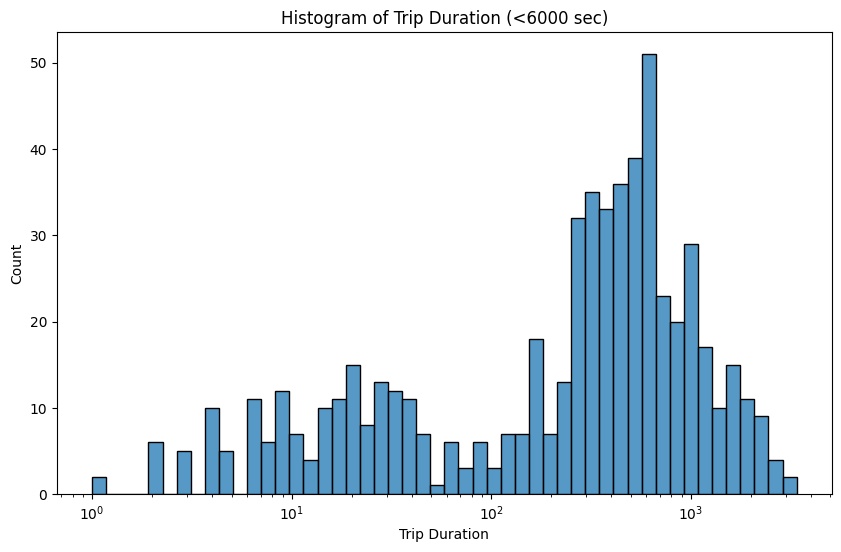

In [19]:
filtered_df = zero_dist_df.filter(F.col("trip_duration") < 6000)

pandas_df = filtered_df.select("trip_duration").sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="trip_duration", bins=50, log_scale=True)
plt.title("Histogram of Trip Duration (<6000 sec)")
plt.xlabel("Trip Duration")
plt.ylabel("Count")
plt.show()

We see that:

- Trip durations of about 15 minutes (900 s) without any distance covered seem hardly possible.

> $\Rightarrow$ We will remove those zero-distance trips that took more than a minute for our continued analysis. Removing them from the modelling might be detrimental if there are similar trips in the test sample.

In [20]:
train_rawData = df_with_speed.filter(
    (F.col("trip_duration") < 22 * 3600) &
    (
        (F.col("distance(m)") > 0) |
        ((F.abs(F.col("distance(m)")) < 1e-6) & (F.col("trip_duration") < 60))
    )
)

### **4. Conclude**

In [21]:
train_rawData.summary().show()

+-------+---------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|     pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|    trip_duration|       distance(m)|       speed(km/h)|
+-------+---------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+
|  count|  1452518|           1452518|           1452518|            1452518|             1452518|            1452518|            1452518|           1452518|          1452518|           1452518|           1452518|
|   mean|     NULL|1.5336691180419106|1.6634403153695858| -73.97354403188294|  40.750948382812524| -73.97347638282481|  40.75182821883599|      

# **III. Structured API Implementation (High-Level)**

### **2. Train-val split**

We reuse the `train_rawData` that we just clean previously as it use the Structured API Dataframe for convenient.

In [22]:
(train_df, val_df) = train_rawData.randomSplit([0.8, 0.2], seed=42)

### **3. Pre-process data**

Drop id column (This is not necessary when training)

In [23]:
train_df = train_df.drop("id")
val_df = val_df.drop("id")
test_df = test_rawData.drop("id")

Handle `pickup_datetime` column which have timestamp data type

In [24]:
for df in [train_df, val_df, test_df]:
    df = df.withColumn("pickup_hour", F.hour(df["pickup_datetime"]))
    df = df.withColumn("pickup_dayofweek", F.dayofweek(df["pickup_datetime"]))
    df = df.withColumn("pickup_month", F.month(df["pickup_datetime"]))

train_df = train_df.drop("pickup_datetime", "dropoff_datetime")
val_df = val_df.drop("pickup_datetime", "dropoff_datetime")
test_df = test_df.drop("pickup_datetime", "dropoff_datetime")

Handle `store_and_fwd_flag` column which have string data type

In [25]:
indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_flag_index")
train_df = indexer.fit(train_df).transform(train_df).drop("store_and_fwd_flag")
val_df = indexer.fit(val_df).transform(val_df).drop("store_and_fwd_flag")
test_df = indexer.fit(test_df).transform(test_df).drop("store_and_fwd_flag")

Remove label column

In [26]:
inputCols = [col for col in train_df.columns if col != "trip_duration"]

Assemble numeric feature

In [27]:
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

Feature indexing - handle categorical features automatically

In [28]:
feature_indexer = VectorIndexer(
    inputCol="features",
    outputCol="indexedFeatures",
    maxCategories=4  # Features with ≤4 distinct values are treated as categorical
).fit(assembler.transform(train_df))

### **4. Train the Decision Tree Regressor model using MLlib**

Define Decision Tree model with parameters

In [29]:
dt = DecisionTreeRegressor(
    featuresCol="indexedFeatures",
    labelCol="trip_duration",
    maxBins=32,
    maxDepth=15,                     # Control model complexity
    minInstancesPerNode=20,         # Prevent overfitting
    impurity="variance"             # Variance for regression
)

Create pipeline

In [30]:
pipeline = Pipeline(stages=[
    assembler,
    feature_indexer,
    dt
])

Create evaluators for different metrics

In [31]:
rmse_evaluator = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="rmse"
)

r2_evaluator = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="r2"
)

Train model

In [32]:
model = pipeline.fit(train_df)

25/05/06 21:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1392.3 KiB
25/05/06 21:55:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Make predictions on validation

In [33]:
val_predictions = model.transform(val_df)

### **5. Evaluation model**

Analyze model structure and feature importance

In [34]:
tree_model = model.stages[2]  # DecisionTreeRegressor is the 3rd stage in pipeline

print("\nDecision Tree Model Summary:")
print("Depth:", tree_model.depth)
print("Number of Nodes:", tree_model.numNodes)
print("Feature importances:")
for col, imp in zip(inputCols, tree_model.featureImportances):
    print(f"- {col}: {imp:.2f}")


Decision Tree Model Summary:
Depth: 15
Number of Nodes: 23959
Feature importances:
- vendor_id: 0.00
- passenger_count: 0.00
- pickup_longitude: 0.02
- pickup_latitude: 0.01
- dropoff_longitude: 0.01
- dropoff_latitude: 0.01
- distance(m): 0.60
- speed(km/h): 0.36
- store_and_fwd_flag_index: 0.00


Evaluate on validation set

In [35]:
val_rmse = rmse_evaluator.evaluate(val_predictions)
val_r2 = r2_evaluator.evaluate(val_predictions)

25/05/06 21:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1942.6 KiB
25/05/06 21:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1942.6 KiB


In [36]:
print("\nModel Evaluation Results:")
print("Validation Set:")
print("Root Mean Squared Error (RMSE) =", val_rmse)
print("R-squared (R²) =", val_r2)


Model Evaluation Results:
Validation Set:
Root Mean Squared Error (RMSE) = 467.730516591051
R-squared (R²) = 0.6831307493385852


# **IV. MLlib RDD-Based Implementation**

## Read data

In [56]:
train_lines = sc.textFile("file:///home/phatle1578/BigData/Practical Exercises/HW3/train.csv")
train_header = train_lines.first()
train_rawData = train_lines.filter(lambda line: line != train_header)

test_lines = sc.textFile("file:///home/phatle1578/BigData/Practical Exercises/HW3/train.csv")
test_header = test_lines.first()
test_rawData = test_lines.filter(lambda line: line != test_header)

## Parsing and pre-process the data file

In [57]:
def parse(row):
    try:
        parts = row.split(",")
        pickup_lat = float(parts[6])
        pickup_long = float(parts[5])
        dropoff_lat = float(parts[8])
        dropoff_long = float(parts[7])
        trip_duration = float(parts[10])
        
        # Calculate distance
        def haversine(lat1, lon1, lat2, lon2):
            R = 6371  # Earth radius in km
            lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * atan2(sqrt(a), sqrt(1-a))
            return R * c * 1000  # meters
        
        dist = haversine(pickup_lat, pickup_long, dropoff_lat, dropoff_long)
        
        # Apply filters
        if (trip_duration < 22*3600 and 
            (dist > 0 or (abs(dist) < 1e-6 and trip_duration < 60))):
            
            # Create features
            features = [
                float(parts[1]),  # vendor_id
                float(parts[4]),  # passenger_count
                pickup_long,
                pickup_lat,
                dropoff_long,
                dropoff_lat,
                float(1.0 if parts[9].strip().upper() == 'Y' else 0.0),  # store_and_fwd_flag
                dist
            ]
            
            return LabeledPoint(trip_duration, features)
        return None
    except Exception as e:
        print(f"Error processing row: {e}")
        return None
    
train_parsed = train_rawData.map(parse).filter(lambda x: x is not None).cache()
test_parsed = test_rawData.map(parse).filter(lambda x: x is not None).cache()

## Train-val split

In [59]:
train_data, val_data = train_parsed.randomSplit([0.8, 0.2], seed=42)

## Train the Decision Tree Regressor model using MLlib

Define Decision Tree model with parameters

In [60]:
dt_model = DecisionTree.trainRegressor(
    train_data,
    categoricalFeaturesInfo={},
    impurity="variance",
    maxDepth=15,
    maxBins=32,
    minInstancesPerNode=20
)

25/05/06 22:08:07 WARN BlockManager: Task 222 already completed, not releasing lock for rdd_373_0
25/05/06 22:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB
25/05/06 22:08:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Make predictions on validation

In [61]:
# Tính toán dự đoán và nhãn (trên driver)
predictions = dt_model.predict(val_data.map(lambda x: x.features))

# Chuyển thành list để tính toán thủ công (với tập nhỏ)
labelsAndPredictions = val_data.map(lambda lp: lp.label).zip(predictions)

## Evaluation model

In [62]:
def evaluate_metrics(labelsAndPredictions):
    # Tính toán các giá trị cần thiết
    metrics = labelsAndPredictions.map(
        lambda x: (1, x[0], x[1], (x[0] - x[1]) ** 2, x[0] ** 2)
    ).reduce(
        lambda a, b: (
            a[0] + b[0],  # count (n)
            a[1] + b[1],  # sum of labels (sum(y))
            a[2] + b[2],  # sum of predictions (sum(y_hat))
            a[3] + b[3],  # sum of squared errors (sum((y - y_hat)^2))
            a[4] + b[4]   # sum of squared labels (sum(y^2))
        )
    )

    n = metrics[0]
    if n == 0:
        return {"RMSE": 0, "R2": 0}

    mse = metrics[3] / n
    rmse = mse ** 0.5  # RMSE = sqrt(MSE)

    ss_total = metrics[4] - (metrics[1] ** 2) / n  # sum((y - mean(y))^2)
    ss_residual = metrics[3]  # sum((y - y_hat)^2)
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else 0.0  # R² = 1 - (SS_res / SS_total)

    return {"RMSE": rmse, "R2": r2}

metrics = evaluate_metrics(labelsAndPredictions)

print("\nModel Evaluation Results:")
print("Validation Set:")
print("Root Mean Squared Error (RMSE) =", metrics["RMSE"])
print("R-squared (R²) =", metrics["R2"])

25/05/06 22:08:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB



Model Evaluation Results:
Validation Set:
Root Mean Squared Error (RMSE) = 702.5133968797255
R-squared (R²) = 0.3720566438706119


# **Reference**

1. [Spark Document - Decistion Tree Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-regression)

2. [Spark Document - Decision Trees(RDD-based API)](https://spark.apache.org/docs/latest/mllib-decision-tree.html)